In [1]:
#NOTE: I would recommend looking at the bottom of the file and see the main chunk of code that calls on different functions.
#      I structured my code to have the functions on top and "running" code on the bottom. It should be easier to run through
#      this main code and look at the functions as they come up.

#general imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
from astropy.time import Time
from astropy.io import ascii
import astropy
import seaborn as sns
import os
from decimal import *
from PyAstronomy import pyasl

import time

#old code when just analyzing 4 brown dwarfs -- don't mind it
WISE = dict() #key: number, values: a_0, d_0, mu_a, mu_d, pi_trig, mu_a_min, mu_a_max, mu_d_min, mu_d_max, pi_trig_min, pi_trig_max
WISE['0825+2805'] = [126.3 * 3600, 28.1 * 3600, -0.0644, -0.2347, 0.1390, -0.06988, -0.05882, -0.24009, -0.22937, 0.13469, 0.14335]
WISE['1738+2732'] = [264.6 * 3600, 27.5 * 3600, 0.3433, -0.3406, 0.1363, 0.33982, 0.34672, -0.3498, -0.33728, 0.13199, 0.14053]
WISE['0336-0143'] = [54.0 * 3600, -1.7 * 3600, -0.2474, -1.2135, 0.1009, -0.2534, -0.2413, -1.21953, -1.20747, 0.09504, 0.10676]
WISE['2209+2711'] = [332.3 * 3600, 27.2 * 3600, 1.1996, -1.3590, 0.1544, 1.19461, 1.20449, -1.36376, -1.35424, 0.14874, 0.16008]

C:\Users\judah\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\judah\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'finding range of theta max for microlensing')

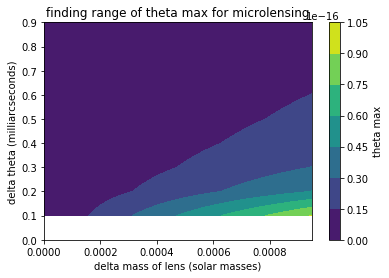

In [2]:
#before we start, I need to find a good reference for maximum theta for microlensing. I do this by making delta theta
#and delta Ml as variable, and finding the theta max for each point.

#However: we ended up not using this strategy. So don't mind it either.

x = np.arange(0, 9.548 * math.pow(10, -4), 0.00001) #solar mass of jupiter as maximum
y = np.arange(0, 1, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)

#constants
big_g = 4.3 * math.pow(10, -3) #pc * solar_mass^-1 * (km/s)^2
c_squared = 9 * math.pow(10, 10) #(km/s)^2
d_l = 20 #parsecs, picked largest value for smallest theta_max and most certainty of lensing event

z = (4 * big_g * xx) / (c_squared * d_l * yy)

h = plt.contourf(x,y,z)

colorbar = plt.colorbar(h)
colorbar.set_label('theta max')

plt.xlabel('delta mass of lens (solar masses)')
plt.ylabel('delta theta (milliarcseconds)')
plt.title('finding range of theta max for microlensing')

In [3]:
#below there are two functions to parse the ephemerides from JPL. For some reason the files with a smaller number of years
#was formatted differently than the files with a larger number of years. Because I started with 10 years and moved to 
#50, I needed to create another function to parse the differently formatted, larger number of years file.

##
# Name: parse_small
#
# inputs: ephemerides file from JPL horizons
# outputs: dictionary of all ephemerides in vector form (X, Y, Z)
#
# purpose: make ephemerides from file easily accessible for me later. goes eph_dict[time] = [X, Y, Z].
#
def parse_small(file):
    eph = open(file, 'r')
    eph_l = list()
    eph_l_2 = list()
    eph_dict = dict()
    eph_dict_2 = dict()
    
    for i in eph.readlines():
        eph_l.append(i.rstrip())

    for i in range(len(eph_l)):
        if "X =" in eph_l[i]:
            eph_dict[eph_l[i-1]] = eph_l[i]      
            
    for i in eph_dict:
        a = i.split(' ')
        a = a[0]
        eph_dict_2[a] = eph_dict[i]
    
    for i in eph_dict_2:
        #getting value in eph_dict_2 to be list of x,y,z
        eph_dict_2[i] = eph_dict_2[i].replace('X', '')
        eph_dict_2[i] = eph_dict_2[i].replace('Y', '')
        eph_dict_2[i] = eph_dict_2[i].replace('Z', '')
        eph_dict_2[i] = eph_dict_2[i].replace('=', '')
        eph_dict_2[i] = eph_dict_2[i].split()

        for x in range(len(eph_dict_2[i])):
            eph_dict_2[i][x] = float(eph_dict_2[i][x])
        
    eph.close()
    return eph_dict_2

##
# Name: parse_large
#
# inputs: ephemerides file from JPL horizons
# outputs: dictionary of all ephemerides in vector form (X, Y, Z)
#
# purpose: make ephemerides from file easily accessible for me later. goes eph_dict[time] = [X, Y, Z].
#
def parse_large(file):
    eph = open(file, 'r')
    eph_l = list()
    eph_l_2 = list()
    eph_l_3 = list()
    eph_dict = dict()
    
    for i in eph.readlines():
        eph_l.append(i.rstrip())
        
    SOE = False #getting just values and dates from file
    for i in eph_l:
        if i == '$$EOE':
            SOE = False
        if SOE == True:
            eph_l_3.append(i)
        if i == '$$SOE':
            SOE = True

    for i in eph_l_3:
        sublist = list()
        a = i.split(',')
        a = ''.join(a)
        a = a.split(' ')
        for x in a:
            try:
                #remove some annoying equal signs
                if x[0] == "=":
                    x = x[1:]
                
                if x.isdigit and float(x) > 10000:
                    b = x
                if x.isdigit and float(x) < 10000:
                    sublist.append(float(x))
            except:
                True
        
        eph_dict[b] = sublist
    
    eph.close()
    return eph_dict

eph_dict_3 = parse_large('horizons_results_50.txt')

#for now cutting eph_dict_3 to 2020 - 2030 to see how the graph looks
eph_dict_3_cut = dict()
for i in eph_dict_3:
    if 2458848.5 <= float(i) <= 2462498.5:
        eph_dict_3_cut.update({i: (eph_dict_3[i][0], eph_dict_3[i][1], eph_dict_3[i][2])})
eph_dict_3 = eph_dict_3_cut

In [4]:
##
# Name: number_only
#
# input: a string with numbers and letters
# output: the string with only numbers
#
# purpose: used in data with form: number +or- error. I wanted only the number, so I made this recursive function.
#          Its purpose is easy to understand, but can be seen in path_list function.
#
def number_only(string):
    string = string.replace(" ", "")
    
    for i in range(len(string)):
        try:
            float(string)
            return string
        except:
            return number_only(string[:len(string) - 1])

In [5]:
##
# Name: path_list
#
# inputs: data from the brown dwarf (like initial position, parallax, etc) and ephemerides from JPL Horizons
# outputs: list of coordinates of brown dwarf through time, ra and dec ends of brown dwarf (for image resizing purposes)
#          and magnitude of proper motion of star (used to formerly put mag proper motion on graphs. no use anymore).
#
# purpose: create list of tuples containing coord in ephemerides. So I can plot later on.
#
def path_list(star_data, eph_dict, error = False):
    place_l = list()
    coord_dict = dict()
    
    #first need to pull general data on brown dwarf
    a_0 = star_data[1] * 3600
    d_0 = star_data[2] * 3600
    
    pi_trig = float(number_only(star_data[3])) / 1000
    mu_a = float(number_only(star_data[4])) / 1000
    mu_d = float(number_only(star_data[5])) / 1000
    
    #errors to add in if needed    
    pi_trig_e = float(star_data[3][len(star_data[3])-4:]) / 1000
    mu_a_e = float(star_data[4][len(star_data[4])-4:]) / 1000
    mu_d_e = float(star_data[5][len(star_data[5])-4:]) / 1000
    
    if error == 'high':
        pi_trig += pi_trig_e
        mu_a += mu_a_e
        mu_d += mu_d_e
    elif error == 'low':
        pi_trig -= pi_trig_e
        mu_a -= mu_a_e
        mu_d -= mu_d_e
        
    t_0 = 2014.0 #when observations happened
    
    #run through each ephemeride coordinate/time (time as months)
    for coord in eph_dict:
        #converting coord to year
        t = Time(float(coord), format='jd')
        t.format = 'jyear'
        t = t.value
        
        #cue formula for ra and dec at a given time.
        
        d_prime = d_0 + (mu_d * (t - t_0))
        #converting d to rad
        d_prime_r = d_prime / 206265

        a_prime = a_0 + (mu_a * (t - t_0) / (np.cos(d_prime_r)))
        #convert a to rad
        a_prime_r = float(a_prime / 206265)

        a_t = a_prime + ((pi_trig * ((eph_dict[coord][0] * np.sin(a_prime_r)) - (eph_dict[coord][1] * np.cos(a_prime_r))) / np.cos(d_prime_r)))
        d_t = d_prime + (pi_trig * ((eph_dict[coord][0] * np.cos(a_prime_r) * np.sin(d_prime_r)) + (eph_dict[coord][1] * np.sin(a_prime_r) * np.sin(d_prime_r)) - (eph_dict[coord][2] * np.cos(d_prime_r))))

        #convert a_t and d_t to degrees
        a_t = a_t / 3600
        d_t = d_t / 3600
        
        #add to the coord_dict with format: coord_dict[time] = [RA, Dec]
        coord_dict[t] = [a_t, d_t]
    
    #find list of alpha and dec to find the end points (for graphing purposes: to zoom into the path itself)
    a_list = list()
    d_list = list()
    for i in coord_dict:
        a_list.append(coord_dict[i][0])
        d_list.append(coord_dict[i][1])
    plt.scatter(a_list, d_list, s=0.5)

    a_ends = [list(coord_dict.values())[0][0], list(coord_dict.values())[len(a_list) - 1][0]]
    d_ends = [list(coord_dict.values())[0][1], list(coord_dict.values())[len(a_list) - 1][1]]
    
    #find mag_mu (for the title on the graph)
    mag_mu = math.sqrt((math.pow(mu_a, 2) + math.pow(mu_d, 2)))

    return coord_dict, a_ends, d_ends, mag_mu

In [6]:
#find ends and slope of uncertainty regions:
def uncertainty_lines(star_data, eph_dict):
    #high uncertainty
    coord_dict_h, a_ends_h, d_ends_h, _ = path_list(star_data, eph_dict, error = 'high')
    
    #low uncertinaty
    coord_dict_l, a_ends_l, d_ends_l, _ = path_list(star_data, eph_dict, error = 'low')
    
    #find the slope of the uncertainties so I can plot it later
    slope_h = (d_ends_h[1] - d_ends_h[0]) / (a_ends_h[1] - a_ends_h[0])
    slope_l = (d_ends_l[1] - d_ends_l[0]) / (a_ends_l[1] - a_ends_l[0])
    
    high_ends = (a_ends_h, d_ends_h)
    low_ends  = (d_ends_h, d_ends_l)
    slopes = (slope_h, slope_l)
    
    return high_ends, low_ends, slopes

In [7]:
#These functions below filter the background stars by magnitude. They all achieve the same purpose. Sorry the names 
#are confusing. DECaLS has some background stars as magnitude 'Infinity' and some 'NaN'. The way removing them works,
#I can't call to remove 'Infinity' values without 'Infinity' being in the dataframe. So, this seemed like the best option.

##
# Name: filter_stars
#
# input: dataframe of background stars
# output: modified dataframe of background stars
#
# purpose: filter out stars don't know mag_r of
#
def filter_stars(stars):
    mags = list()
    
    #filtering NaN, Infinity, and 0<=star<=30 values
    df = pd.DataFrame(stars)
    
    df = df.replace('Infinity', np.nan) #replace infinities with nan
    df = df.dropna(subset=['dered_mag_r']) #drop nan
    
    df['dered_mag_r'] = pd.to_numeric(df['dered_mag_r'])
    
    df = df[df.dered_mag_r >= 0]
    df= df[df.dered_mag_r <= 30]

    return df

##
# Name: star_mag_r
#
# input: dataframe of background stars
# output: modified dataframe of background stars
#
# purpose: filter out stars don't know mag_r of
#
def star_mag_r(stars):
    mags = list()
    
    #filtering NaN, Infinity, and 0<=star<=30 values
    df = pd.DataFrame(stars)
    df = df.replace('Infinity', np.nan) #replace infinities with nan
    df = df.dropna(subset=['dered_mag_r']) #drop nan
    
    df['dered_mag_r'] = pd.to_numeric(df['dered_mag_r'])
    
    df = df[df.dered_mag_r >= 0]
    df = df[df.dered_mag_r <= 30]

    df1 = df['dered_mag_r']
    
    return df1

##
# Name: star_filter
#
# input: dataframe of background objects
# output: modified dataframe of just background stars
#
# purpose: filter out objects in dataframe that aren't stars (like galaxies) 
#
def star_filter(dataset):
    drop_l = list()
    for i in range(len(dataset['type'])):
        if dataset['type'][i] != 'PSF':
            drop_l.append(i)

    return dataset.drop(drop_l, axis=0)

In [8]:
##
# Name: theta_max_calc
# 
# inputs: data from the stars
# outputs: theta_max for that individual star
#
# purpose: calculate theta max for a given parallax for each brown dwarf. So I can use to include any dwarf-background star
#          pairs that are under the theta max for astrometric microlensing. I didn't want to miss any.
#
def theta_max_calc(star_data):
    #get parallax and astrometric precision.
    #parallax requires some data because it has a +or- I don't want. I could've used my number_only function above, but I 
    #guess I forgot about it when I wrote this code.
    point = 0
    parallax = star_data[3]
    for i in range(len(parallax)):
        if parallax[i] == ' ':
            point = i
            break
    parallax = float(parallax[:point]) / 1000 #convert from mas to arcseconds         

    #astro_precision = float(parallax[(point + 6):]) #in milliarcseconds
    #astro_precision = 0.02 #cushings example
    astro_precision = 0.005 #gaia potential precision

    
    #constants
    big_g = 4.3 * math.pow(10, -3) #pc * solar_mass^-1 * (km/s)^2
    c_squared = (2.997 * math.pow(10, 8)) ** 2 #(km/s)^2
    d_l = (1 / parallax) #in parsecs
    delta_ml = 4 * 9.548 * math.pow(10, -4) #mass of jupiter -- what would like (changed to 4 Mjup for test)
    #delta_ml = 0.1 #cushing's example
    k = 8.144 #mas/solar masses
    
    #actual formula. Used k one because was easiest.
    theta_max = (k * delta_ml * parallax) / (astro_precision)
    #theta_max = (4 * big_g * delta_ml) / (c_squared * d_l * astro_precision)

    return theta_max

In [9]:
##
# Name: delta_ml_calc
#
# inputs: brown dwarf data, a theta
# outputs: a delta_ml by Cushing's formula
#
# purpose: when I have called this function, I have the smallest theta between dwarfs and background stars for each
#          dwarf. So I need to find the delta_ml to see how helpful microlensing would be.
#
def delta_ml_calc(star_data, theta):
    #get parallax and astrometric precision
    #parallax requires some data because it has a +or- I don't want. I could've used my number_only function above, but I 
    #guess I forgot about it when I wrote this code.
    point = 0
    parallax = star_data[3]
    for i in range(len(parallax)):
        if parallax[i] == ' ':
            point = i
            break 
    parallax = float(parallax[:point]) / 1000 #convert from mas to arcseconds
    
    astro_precision = 0.005 #gaia potential precision
    k = 8.144 #mas/solar masses
    
    #using helpful formula
    delta_ml = (theta * astro_precision) / (k * parallax)
    
    delta_ml = delta_ml / (9.548 * math.pow(10, -4)) #making into jupiter masses
    
    return delta_ml

In [10]:
##
# Name: events_per_year_calc
#
# inputs: brown dwarf data, background stars
# outputs: number of events per year
#
# purpose: previously wanted to know how many events per year should be occuring. I used it as a check for my microlensing
#          events output. I may use it again, so I kept it.
#
def events_per_year_calc(star_data, bs):
    #calculate the number of expected microlensing events per year for a given brown dwarf
    k = 8.144 #mas/solar masses

    #get parallax and astrometric precision
    point = 0
    parallax = star_data[3]
    for i in range(len(parallax)):
        if parallax[i] == ' ':
            point = i
            break    
    #astro_precision = float(parallax[(point + 6):]) #in milliabrcseconds
    astro_precision2 = 0.05 #cushing's example
    astro_precision = 0.005 #gaia potential precision
    parallax = float(parallax[:point]) / 1000 #convert from mas to arcseconds
    
    mu_a = float(number_only(star_data[4]))
    mu_d = float(number_only(star_data[5]))
    mu = math.sqrt((mu_a ** 2) + (mu_d ** 2))
    
    #formula from Cushing et al. I have delta_ml and delta_ml2 for two different Ml's (cushing and ours). Subsequently,
    #I also have two events per year. I last used our delta_ml, so I return our number
    sigma = len(bs) / (np.pi * ((5 * 60) ** 2)) #the surface density of stars per arcsecond^2 (#stars / area of view with radius 5 degrees)
    delta_ml = 4 * 9.548 * math.pow(10, -4) #solar mass of jupiter -- what would like (changed to 4 Mjup for test)
    delta_ml2 = 0.1 #cushings example
    
    number = 2 * k * parallax * sigma * (delta_ml / astro_precision)
    number2 = 2 * k * parallax * sigma * (delta_ml2 / astro_precision2)
    
    return number

In [11]:
##
# Name: close_star_find
#
# inputs: background stars, path of brown dwarf, ends of brown dwarf (to cut the stars looked at for nearness to save time),
#         data from brown dwarf for a delta_ml calc, a theta_max for that specific brown dwarf if delta_ml is 4, radius that
#         I'll explain in the purpose.
# outputs: dictionary of dwarf and background star pairs that make the cut of closest and/or under theta_max
#
# purpose: to find the closest stars in a certain radius. In the function close_star, I increase the radius to save time in 
#          calculation. I want to get the closest star but also not take lots of calc time for it. I also want to catch fast
#          moving stars' events. All have a different radius, so to objectify it, I have an increasing radius until I hit
#          a star
def close_star_find(bs, path_dict, a_ends, d_ends, star_data, theta_max, radius):
    #make RA and Dec bounds to look at a star
    a_low = a_ends[0] - (radius * abs(a_ends[1] - a_ends[0]))
    a_high = a_ends[1] + (radius * abs(a_ends[1] - a_ends[0]))
    d_low = d_ends[0] - (radius * abs(d_ends[1] - d_ends[0]))
    d_high = d_ends[1] + (radius * abs(d_ends[1] - d_ends[0]))

    full_close_dict = dict()
    
    #The process for this function was to find the theta_min for any background star within the RA and Dec range found
    #through the radius. And then I process by taking the smallest delta_ml and any delta_mls lower than 4.
    
    #run through each background star
    for i in range(len(bs['decals_id'])): 
        #if the star is within the range I am looking at
        if bs.iloc[i,1] > a_low and bs.iloc[i,1] < a_high and bs.iloc[i,2] > d_low and bs.iloc[i,2] < d_high:
            theta_min = 1000
            
            #run through each brown dwarf data point in path
            for j in path_dict: 
                a_1 = path_dict[j][0] #* 2 * np.pi * (1 / 360) #brown dwarf alpha converted to rad
                d_1 = path_dict[j][1] #* 2 * np.pi * (1 / 360) #brown dwarf dec converted to rad
                a_2 = bs.iloc[i, 1] #* 2 * np.pi * (1 / 360) #obj alpha converted to rad
                d_2 = bs.iloc[i, 2] #* 2 * np.pi * (1 / 360) #obj dec converted to rad

                theta_a = a_1 - a_2 #difference in alpha between brown dwarf and background obj
                theta_d = d_1 - d_2 #difference in dec between brown dwarf and backgroun obj
                theta = pyasl.getAngDist(a_1, d_1, a_2, d_2) #angular difference in degrees
                theta = theta * (2 * np.pi * (1 / 360)) * 206264 #convert from radians to arcseconds
                
                #if point is closer to background star than any point I have seen so far, make theta_min and record
                #which background star it is.
                if theta < theta_min and j > 2020:
                    theta_min = theta
                    time_of_min = j

                    background_star_id = bs.iloc[i][0]
                    background_star_mag = bs.iloc[i][4] #dered_mag_r
                    background_star_ra = bs.iloc[i][1]
                    background_star_dec = bs.iloc[i][2]
                    background_star_gaia_flag = bs.iloc[i][11]
            
            #find delta_ml for the smallest theta and add to dictionary.
            delta_ml = delta_ml_calc(star_data = star_data, theta = theta_min)
            full_close_dict[background_star_id] = [star_data[0], theta_max, theta_min, time_of_min, delta_ml, background_star_ra, background_star_dec, background_star_mag, background_star_gaia_flag]
      
    #Now for the processing I explained above. Its pretty complicated but it gets the job done. Basically checks if lower
    #than the known smallest theta or lower than theta_max. Lots of 'under_considerations' as well. Sorry I can't explain 
    #it better. Just know it works.
    cut_close_dict = dict()
    under_consideration = None
    theta_max_check = False
    for i in range(len(full_close_dict)):
        key = list(full_close_dict.keys())[i]
        key_minus_one = list(full_close_dict.keys())[i-1]
        
        #add to cut_close_dict if within parameters
        if full_close_dict[key][2] < full_close_dict[key][1]:
            #show code that there is a star within max
            theta_max_check = True
            under_consideration = None
            
            #add to cut_close_dict (probably an easier way than manually creating a new key/value pair, but just did it that way bc easiest)
            cut_close_dict[key] = [full_close_dict[key][0], full_close_dict[key][1], full_close_dict[key][2], full_close_dict[key][3], full_close_dict[key][4], full_close_dict[key][5], full_close_dict[key][6], full_close_dict[key][7], full_close_dict[key][8]]
        
        elif theta_max_check == False and under_consideration is None:
            under_consideration = [key, full_close_dict[key][0], full_close_dict[key][1], full_close_dict[key][2], full_close_dict[key][3], full_close_dict[key][4], full_close_dict[key][5], full_close_dict[key][6], full_close_dict[key][7], full_close_dict[key][8]]
        
        elif theta_max_check == False:
            #if this background star is less than the one under consideration
            if full_close_dict[key][2] < under_consideration[3]:
                under_consideration = [key, full_close_dict[key][0], full_close_dict[key][1], full_close_dict[key][2], full_close_dict[key][3], full_close_dict[key][4], full_close_dict[key][5], full_close_dict[key][6], full_close_dict[key][7], full_close_dict[key][8]]
   
    #after going through, if no theta under theta_max found, then add smallest
    if under_consideration is not None:
            cut_close_dict[under_consideration[0]] = [under_consideration[1], under_consideration[2], under_consideration[3], under_consideration[4], under_consideration[5], under_consideration[6], under_consideration[7], under_consideration[8], under_consideration[9]] 
   
    return cut_close_dict

In [12]:
##
# Name: close_stars
#
# inputs: background stars, path of brown dwarf, ends of brown dwarf (to cut the stars looked at for nearness to save time),
#         data from brown dwarf for a delta_ml calc, a theta_max for that specific brown dwarf if delta_ml is 4
# outputs: dictionary of dwarf and background star pairs that make the cut of closest and/or under theta_max
#
# purpose: to run close_star_find function and keep on adding to the radius until close_star_find can find a star with the 
#          given radius. Basically just increase the radius unl not given back None.
#
def close_stars(bs, path_dict, a_ends, d_ends, star_data, theta_max):
    #variability of lengths of star paths makes the process below unneeded -- it also is unfinished. So, no reason to keep
    #except that I seem to be a code hoarder and keep my code that I start and end up not needing.
    """
    #filter out stars not within ends of ra and dec +-0.3 change of ra and dec
    a_change = a_ends[1] - a_ends[0]
    a_high = a_ends[1] + (0.3 * a_change)
    a_low = a_ends[0] + (0.3 * a_change)
    
    d_change = d_ends[1] - d_ends[0]
    d_high = d_ends[1] + (0.3 * d_change)
    d_low = d_ends[0] + (0.3 * d_change)
    
    print('len before: ', len(bs['decals_id']))
    drop_list = list()
    for i in range(len(bs['decals_id'])):
        ra = bs.iloc[i, 1] #ra for each background star
        dec = bs.iloc[i, 2] #dec for each background star
        if not ((ra < a_high and ra > a_low) and (dec < d_high and dec > d_low)): #if outside set boundaries
            drop_list.append(i)
    bs.drop(bs.index[drop_list])
    print('len after: ', len(bs['decals_id']))
    """
    
    #continually increase the radius until hit more stars. makes sure get closest star in each while still keeping processing low
    cut_close_dict = {}
    radius = 0
    while len(cut_close_dict.keys()) == 0:
        radius += 0.5
        cut_close_dict = close_star_find(bs = bs, path_dict = path_dict, a_ends = a_ends, d_ends = d_ends, star_data = star_data, theta_max = theta_max, radius = radius)
        
        if radius == 20: #semi-random stopping point
            break
    
    return cut_close_dict

In [17]:
#Now for the juicy, non-function stuff:

#Reading and formatting ascii table to desired format
candidate_stars = ascii.read('apjsaaf6aft4_ascii.txt', format='tab')
candidate_stars.keep_columns(['(1)', '(2)', '(4)', '(6)', '(8)', '(9)'])

candidate_stars.rename_column('(1)', 'object_name')
candidate_stars.rename_column('(2)', 'J2000_ra')
candidate_stars.rename_column('(4)', 'J2000_dec')
candidate_stars.rename_column('(6)', 'pi_abs')
candidate_stars.rename_column('(8)', 'mu_ra')
candidate_stars.rename_column('(9)', 'mu_dec')
print(len(candidate_stars))
#stars decals that had nearby background_stars. I just manually did this.
bs_list = ['2MASS 0034+0523', 'WISE 0038+2758', 'WISE 0049+2151', 'CFBDS 0133+0231', 'WISE 0226-0211AB', 'WISE 0336-0143', 'WISE 0825+2805', 'WISE 0833+0052', 'WISE 0855-0714', 'WISE 0952+1955', 'WISE 1025+0307', 'ULAS 1043+1048', 'WISE 1124-0421', 'ULAS 1152+1134', 'WISE 1217+1626AB', 'WISE 1225-1013', '2MASS 1231+0847', 'WISE 1254-0728', 'WISE 1301-0302', 'VHS 1433-0837', 'WISE 1517+0529', 'WISE 1523+3125', 'WISE 1542+2230', 'WISE 1614+1739', '2MASS 1615+1340', 'WISE 1721+1117', 'WISE 1738+2732', 'WISE 1804+3117', 'WISE 1812+2007', 'WISE 1813+2835', 'WISE 2147-1029', 'WISE 2157+2659', 'WISE 2209+2711', 'WISE 2301+0216', 'WISE 2319-1844', 'ULAS 2321+1354', 'ULAS 2326+0201', 'WISE 2344+1034', 'WISE 2354+0240', 'WISE 2357+1227']
print(len(bs_list))
#keep rows with stars with nearby ephemerides
#needs copy to preserve length of table in for loop
candidate_stars_2 = candidate_stars.copy()
#need different list because .index() cannot do masked columns -- adds lots of unfortunate complexity
candidate_stars_2_o = list(candidate_stars_2['object_name'])
for i in candidate_stars['object_name']:
    if i not in bs_list:
        obj_index = candidate_stars_2_o.index(i)
        candidate_stars_2.remove_row(obj_index)
        candidate_stars_2_o.remove(i)
        
candidate_stars = candidate_stars_2

142
40


In [20]:
#And now for the event juicier stuff and the thing that calls upon the functions above.

count = 0
close_dict = dict()
within_max_dict = dict()

#set plotting style because the plots need to look fancy
with sns.axes_style('darkgrid', {'xtick.bottom': True, 'ytick.left': True}):
    sns.set_context('paper')

    #run through each dwarf's background star data from DECaLS. Sorry ht epath name is confusing with ephemerides --
    #it seems I was equally confused when I made that directory.
    for filename in os.listdir(r'C:\Users\judah\candidate_stars_ephemerides'):
        #create a path of a candidate_star and its error
        #regular
        coord_dict, a_ends, d_ends, mag_mu = path_list(star_data = candidate_stars[count], eph_dict = eph_dict_3, error = False)
        #uncertainty
        #high_ends, low_ends, slopes = uncertainty_lines(star_data = candidate_stars[count], eph_dict = eph_dict_3)
        
        a_list= list()
        d_list = list()
        for i in range(len(coord_dict)):
            a_list.append(coord_dict[list(coord_dict.keys())[i]][0])
            d_list.append(coord_dict[list(coord_dict.keys())[i]][1])
        
        #find star name
        filename_cut = filename[:9]

        #horiz = int(count % 4)
        #vert = int((count - horiz) / 4)

        #plot the dwarf path
        plt.scatter(a_list, d_list, s=0.5)
        #plt.plot([high_ends[1][0], high_ends[1][1]], [high_ends[0][0], high_ends[0][1]])
        #plt.plot([low_ends[1][0], low_ends[1][1]], [low_ends[0][0], low_ends[0][1]])
        
        #add stars into scatter plot
        full_filename = 'C:\\Users\\judah\\candidate_stars_ephemerides\\' + filename
        
        #get background star data and filter
        background_star = pd.read_csv(full_filename)
        background_star = star_filter(background_star)
        background_star = filter_stars(background_star)
        
        #plot the background stars
        bs_plot = plt.scatter(filter_stars(background_star).ra, filter_stars(background_star).dec, s = star_mag_r(background_star), c = star_mag_r(background_star), cmap = 'viridis')
        bs_colorbar = plt.colorbar(bs_plot)
        bs_colorbar.set_label('Background Star Magnitude')
        
        
        #general formatting to the plot. looks better that way.
        plt.title('Candidate Star: ' + filename_cut)
        plt.xlabel(r'$ \alpha_{J2000, deg} $')
        plt.ylabel(r'$ \delta_{J2000, deg}$')
        #set limits +-1 length. I had initially done based on change of ra and dec, but that scaled the plot weird
        path_length = math.sqrt(((a_ends[1] - a_ends[0]) ** 2) + ((d_ends[1] - d_ends[0]) ** 2))
        
        if (a_ends[1] - a_ends[0]) > 0 and (d_ends[1] - d_ends[0]) > 0:
            plt.xlim(a_ends[0] - (0.1 * path_length), a_ends[1] + (0.1 * path_length))
            plt.ylim(d_ends[0] - (0.1 * path_length), d_ends[1] + (0.1 * path_length))
        if (a_ends[1] - a_ends[0]) < 0 and (d_ends[1] - d_ends[0]) > 0:
            plt.xlim(a_ends[0] + (0.1 * path_length), a_ends[1] - (0.1 * path_length))
            plt.ylim(d_ends[0] - (0.1 * path_length), d_ends[1] + (0.1 * path_length))
        if (a_ends[1] - a_ends[0]) > 0 and (d_ends[1] - d_ends[0]) < 0:
            plt.xlim(a_ends[0] - (0.1 * path_length), a_ends[1] + (0.1 * path_length))
            plt.ylim(d_ends[0] + (0.1 * path_length), d_ends[1] - (0.1 * path_length))
        if (a_ends[1] - a_ends[0]) < 0 and (d_ends[1] - d_ends[0]) < 0:
            plt.xlim(a_ends[0] + (0.1 * path_length), a_ends[1] - (0.1 * path_length))
            plt.ylim(d_ends[0] + (0.1 * path_length), d_ends[1] - (0.1 * path_length))
        
        
        #make list of alpha and dec every 10 years and plot them with text as visual markers. easy to see in plot and see
        #direction the dwarf goes.
        year_list_a = list()
        year_list_d = list()
        count2 = 0
        for i in range(len(a_list)):
            count2 += 1
            if count2 % 12 == 0:
                year_list_a.append(a_list[i])
                year_list_d.append(d_list[i])

        plt.scatter(year_list_a, year_list_d, s=5, marker="D")
        
        #adding text to 10 yr plot
        #finding placement to put plots
        delta_a = (a_ends[1] - a_ends[0]) * 0.1
        delta_d = (d_ends[1] - d_ends[0]) * 0.01
        
        count2 = 0
        for i in range(len(year_list_a)):
            count2 += 1
            plt.text(year_list_a[i] - delta_a, year_list_d[i] + delta_d, count2)

        #print filename on so I know where I am at in code
        print('Created plot for', filename_cut)
        
        plt.savefig(r'C:\\Users\\judah\\candidate_stars_plots\\' + filename_cut)
        
        #find which background stars are closest to the path
        theta_max = theta_max_calc(star_data = candidate_stars[count])
        events_per_year = events_per_year_calc(star_data = candidate_stars[count], bs = background_star)
        
        #add to dictionary holding all closest dwarf and background star pairs to call on later.
        temp_close_dict = close_stars(bs = background_star, path_dict = coord_dict, a_ends = a_ends, d_ends = d_ends, star_data = candidate_stars[count], theta_max = theta_max)
        close_dict.update(temp_close_dict)
        #within_max_dict.update(temp_within_max_dict)
        
        plt.clf()
        count += 1

Created plot for 0034+0523
Created plot for 0038+2758
Created plot for 0049+2151
Created plot for 0133+0231
Created plot for 0226-0211
Created plot for 0336-0143
Created plot for 0825+2805
Created plot for 0833+0052
Created plot for 0855-0714
Created plot for 0952+1955
Created plot for 1025+0307
Created plot for 1043+1048
Created plot for 1124-0421
Created plot for 1152+1134
Created plot for 1217+1626
Created plot for 1225-1013
Created plot for 1231+0847
Created plot for 1254-0728
Created plot for 1301-0302
Created plot for 1433-0837
Created plot for 1517+0529
Created plot for 1523+3125
Created plot for 1542+2230
Created plot for 1614+1739
Created plot for 1615+1340
Created plot for 1721+1117
Created plot for 1738+2732
Created plot for 1804+3117
Created plot for 1812+2007
Created plot for 1813+2835
Created plot for 2147-1029
Created plot for 2157+2659
Created plot for 2209+2711
Created plot for 2301+0216
Created plot for 2319-1844
Created plot for 2321+1354
Created plot for 2326+0201
C

<Figure size 432x288 with 0 Axes>

In [ ]:
#check if it worked
print(len(close_dict))
print(len(candidate_stars['object_name']))

#it worked! there are 5 extra events at a mjup of 4. Two candidates also did not have any non infinite magnitudes

In [ ]:
#make table of dictionary of data
#format data into pandas readable form
df_array = list()
for i in close_dict:
    df_array.append([close_dict[i][0], close_dict[i][1], close_dict[i][4], i, close_dict[i][3], close_dict[i][5], close_dict[i][6], close_dict[i][7], close_dict[i][8]])

df = pd.DataFrame(df_array, columns = ['star', 'minimum_theta_predicted_arcseconds', 'delta_ml_for_theta_Mjup', 'background_id', 'time_of_minimum', 'background_ra (arcseconds)', 'background_dec (arcseconds)', 'background_mag', 'gaia_pointsource'])

#make background_id into string so no formatting done
df = df.applymap(str)

df

In [30]:
#add table to csv
df.to_csv('microlensing_table.csv', index = False)

In [42]:
#dwarf/star pairs of astrometric precision below 5 Mjup. Helpful for paper.
df['delta_ml_for_theta_Mjup'] = df.delta_ml_for_theta_Mjup.astype(float)

df_index = df.index[df['delta_ml_for_theta_Mjup'] < 5].tolist()

df2 = df.copy()

df2.iloc[df_index]

,star,minimum_theta_predicted_arcseconds,delta_ml_for_theta_Mjup,background_id,time_of_minimum,background_ra (arcseconds),background_dec (arcseconds),background_mag,gaia_pointsource
8,WISE 0855-0714,2.7302709181439995,0.686448,7696600349215571,2027.160848733744,133.75709531684998,-7.24183164182705,23.6295,0
9,WISE 0855-0714,2.7302709181439995,1.599427,7696600349215541,2020.7488021902807,133.771879062068,-7.24285234204672,20.9807,0
10,WISE 0952+1955,0.255671302656,3.256604,7696610489926820,2020.0835044490075,148.246992225983,19.9189683311398,25.6878,0
